Imports:

In [ ]:
import sqlite3
import geopy
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading Fires Data:

In [ ]:
cnx = sqlite3.connect('/content/drive/My Drive/Data 301 Project/FPA_FOD_20170508.sqlite')
fires = pd.read_sql_query("SELECT * FROM Fires", cnx)
fires

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,021,A32W,SLACK,None,None,None,None,None,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,6,None,DEER,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,7,None,STEVENOT,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,1880461,300348363,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,Shasta-Trinity Unit,591814,009371,None,ODESSA 2,None,None,None,None,None,2015,2457291.5,269,1726,13.0,Missing/Undefined,2457291.5,269.0,1843,0.01,A,40.481637,-122.389375,13.0,STATE OR PRIVATE,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00P\xb8\x1e\x85\xeb\x9...
1880461,1880462,300348373,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,569419,000366,None,None,None,None,None,None,None,2015,2457300.5,278,0126,9.0,Miscellaneous,NaN,NaN,None,0.20,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
1880462,1880463,300348375,2015CAIRS28364460,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,574245,000158,None,None,None,None,None,None,None,2015,2457144.5,122,2052,13.0,Missing/Undefined,NaN,NaN,None,0.10,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
1880463,1880464,300348377,2015CAIRS29218079,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,570462,000380,None,None,None,None,None,None,None,2015,2457309.5,287,2309,13.0,Missing/Undefined,NaN,NaN,None,2.00,B,37.672235,-120.898356,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00x\xba_\xaa~9^\xc0\xb...


Cleaning Fires Data:

In [ ]:
fires = fires[fires['FIRE_YEAR'] >= 2012]
fires = fires[fires['STATE'] == 'CA']
fires = fires[['FIRE_YEAR', 'DISCOVERY_DOY', 'CONT_DOY', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'FIPS_NAME']]
fires = fires.dropna(subset = ['CONT_DOY'])

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
daysnl = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
daysl = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
def doy_to_month(doy, year):
  month = ""
  counter = 0
  while doy >= 1:
    if year == 2012:
      doy -= daysl[counter]
    else:
      doy -= daysnl[counter]
    month = months[counter]
    counter += 1
  return month
def doy_to_dom(doy, year, month):
  monthindex = months.index(month)
  for i in range(0, monthindex):
    if year == 2012:
      doy -= daysl[i]
    else:
      doy -= daysnl[i]
  return doy
def month_to_num_rep(month):
  return months.index(month) + 1
fires['MONTH'] = np.vectorize(doy_to_month)(fires['DISCOVERY_DOY'], fires['FIRE_YEAR'])
fires['MONTH_AS_NUM'] = np.vectorize(month_to_num_rep)(fires['MONTH'])
fires['DOM'] = np.vectorize(doy_to_dom)(fires['DISCOVERY_DOY'], fires['FIRE_YEAR'], fires['MONTH'])
fires['DURATION'] = fires['CONT_DOY'] - fires['DISCOVERY_DOY']
fires = fires[['MONTH', 'FIRE_YEAR', 'DOM', 'FIRE_SIZE', 'DURATION', 'LATITUDE', 'LONGITUDE', 'FIPS_NAME', 'MONTH_AS_NUM']]
fires.columns = ['MONTH', 'YEAR', 'DAY_OF_MONTH', 'SIZE', 'DURATION', 'LATITUDE', 'LONGITUDE', 'COUNTY', 'MONTH_AS_NUM']
fires = fires.sort_values(by = ['LATITUDE', 'LONGITUDE'])
fires = fires.fillna(method = "ffill", axis = "rows")

Loading Weather Month Data:

In [ ]:
ca_weather = pd.read_csv('/content/drive/My Drive/Data 301 Project/4-tavg.csv', delimiter=',')

Cleaning Weather Month Data:

In [ ]:
ca_weather['Date'] = ca_weather['Date'].astype(str)
ca_weather['Date'] = pd.to_datetime(ca_weather['Date'], format = '%Y%m')
ca_weather['Location'] = ca_weather['Location'].str.replace("County", " ").str.strip()

def strip_year(date):
  date = pd.to_datetime(str(date))
  return date.strftime('%Y')
def strip_month(date):
  date = pd.to_datetime(str(date))
  return date.strftime('%B')
  
ca_weather['Year'] = np.vectorize(strip_year)(ca_weather['Date'])
ca_weather['Month'] = np.vectorize(strip_month)(ca_weather['Date'])
ca_weather['Year'] = ca_weather['Year'].astype(int)
ca_weather = ca_weather[ca_weather['Year'] >= 2012]
ca_weather = ca_weather[ca_weather['Year'] <= 2015]
ca_weather = ca_weather[['Location', 'Year', 'Month', 'Value']]
ca_weather.columns = ['COUNTY', 'YEAR', 'MONTH', 'VALUE']

Merging The Two Data:

In [ ]:
df = pd.merge(fires, ca_weather, on = ['YEAR', 'MONTH', 'COUNTY'])
df = df.sort_values(by = ['COUNTY', 'YEAR'])

In [ ]:
df.columns = ["Month", "Year", "Day", "Size", "Duration", "Lat", "Long", "County", "Month_n", "Month_Temp"]
df

,Month,Year,Day,Size,Duration,Lat,Long,County,Month_n,Month_Temp
9723,August,2012,17,2.00,1.0,37.595600,-119.595500,Alameda,8,71.0
9724,August,2012,18,0.10,0.0,37.630010,-119.573650,Alameda,8,71.0
9725,August,2012,11,1.00,3.0,37.728840,-119.544040,Alameda,8,71.0
9726,August,2012,31,0.10,0.0,37.742200,-119.627200,Alameda,8,71.0
9727,August,2012,28,0.10,0.0,37.742630,-119.577490,Alameda,8,71.0
...,...,...,...,...,...,...,...,...,...,...
14970,February,2015,26,1.00,0.0,39.470636,-121.318982,Yuba,2,55.4
14989,August,2015,21,0.02,0.0,39.243640,-121.354048,Yuba,8,76.7
14990,August,2015,7,0.10,1.0,39.294017,-120.411083,Yuba,8,76.7
14991,August,2015,13,5.20,0.0,39.300720,-121.376961,Yuba,8,76.7


Removing irrelevant Couties

In [ ]:
reduced = df.query("County == 'San Diego' | County == 'Los Angeles' | County == 'San Mateo' | County == 'Santa Clara' | County == 'Alameda' | County == 'Contra Coasta'")
reduced

,Month,Year,Day,Size,Duration,Lat,Long,County,Month_n,Month_Temp
9723,August,2012,17,2.00,1.0,37.595600,-119.595500,Alameda,8,71.0
9724,August,2012,18,0.10,0.0,37.630010,-119.573650,Alameda,8,71.0
9725,August,2012,11,1.00,3.0,37.728840,-119.544040,Alameda,8,71.0
9726,August,2012,31,0.10,0.0,37.742200,-119.627200,Alameda,8,71.0
9727,August,2012,28,0.10,0.0,37.742630,-119.577490,Alameda,8,71.0
...,...,...,...,...,...,...,...,...,...,...
8924,June,2015,24,2.00,0.0,37.220500,-121.734233,Santa Clara,6,69.0
8925,June,2015,18,1.00,0.0,37.256350,-121.694917,Santa Clara,6,69.0
9086,March,2015,10,1.30,0.0,37.159317,-118.295533,Santa Clara,3,58.4
9087,March,2015,31,0.08,0.0,37.205503,-119.724582,Santa Clara,3,58.4


Creating datetime column

In [ ]:
from datetime import datetime

def convert_to_dt(i_year, i_month, i_day):
  return datetime(year = i_year, month = i_month, day = i_day)

reduced["datetime"] = np.vectorize(convert_to_dt)(reduced['Year'], reduced['Month_n'], reduced["Day"])
reduced

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Month,Year,Day,Size,Duration,Lat,Long,County,Month_n,Month_Temp,datetime
9723,August,2012,17,2.00,1.0,37.595600,-119.595500,Alameda,8,71.0,2012-08-17
9724,August,2012,18,0.10,0.0,37.630010,-119.573650,Alameda,8,71.0,2012-08-18
9725,August,2012,11,1.00,3.0,37.728840,-119.544040,Alameda,8,71.0,2012-08-11
9726,August,2012,31,0.10,0.0,37.742200,-119.627200,Alameda,8,71.0,2012-08-31
9727,August,2012,28,0.10,0.0,37.742630,-119.577490,Alameda,8,71.0,2012-08-28
...,...,...,...,...,...,...,...,...,...,...,...
8924,June,2015,24,2.00,0.0,37.220500,-121.734233,Santa Clara,6,69.0,2015-06-24
8925,June,2015,18,1.00,0.0,37.256350,-121.694917,Santa Clara,6,69.0,2015-06-18
9086,March,2015,10,1.30,0.0,37.159317,-118.295533,Santa Clara,3,58.4,2015-03-10
9087,March,2015,31,0.08,0.0,37.205503,-119.724582,Santa Clara,3,58.4,2015-03-31


removing unnecessary data

In [ ]:
from datetime import datetime

def convert_name(name):
  if name == "Los Angeles" or name == "San Diego":
    return name
  return "San Francisco"

reduced["City"] = np.vectorize(convert_name)(reduced['County'])
reduced = reduced.drop(["County", "Month", "Year", "Day", "Month_n", "Lat", "Long"], axis = 1)
reduced

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Size,Duration,Month_Temp,datetime,City
9723,2.00,1.0,71.0,2012-08-17,San Francisco
9724,0.10,0.0,71.0,2012-08-18,San Francisco
9725,1.00,3.0,71.0,2012-08-11,San Francisco
9726,0.10,0.0,71.0,2012-08-31,San Francisco
9727,0.10,0.0,71.0,2012-08-28,San Francisco
...,...,...,...,...,...
8924,2.00,0.0,69.0,2015-06-24,San Francisco
8925,1.00,0.0,69.0,2015-06-18,San Francisco
9086,1.30,0.0,58.4,2015-03-10,San Francisco
9087,0.08,0.0,58.4,2015-03-31,San Francisco


getting the daily weather conditions

definitions

In [ ]:
def convert_to_dt(time):
    time = time.split(" ")[0]
    time = time.split("-")
    return datetime(year = int(time[0]), month = int(time[1]), day = int(time[2]))

Humidity

In [ ]:
humidity = pd.read_csv('/content/drive/My Drive/Data 301 Project/humidity.csv', delimiter = ',', engine = 'python')
humidity = humidity[["datetime", "Los Angeles", "San Diego", "San Francisco"]]
humidity = humidity.fillna(method = "ffill", axis = "rows").dropna()
humidity = humidity.set_index(['datetime'])
humidity = pd.DataFrame(humidity.stack()).reset_index()
humidity.columns = ["datetime", "City", "Humidity"]
humidity["datetime"] = np.vectorize(convert_to_dt)(humidity["datetime"])
humidity = humidity.groupby(['datetime', "City"]).mean().reset_index()
data = pd.merge(reduced, humidity, left_on = ["datetime", "City"], right_on = ["datetime", "City"])

Pressure 4

In [ ]:
pressure = pd.read_csv('/content/drive/My Drive/Data 301 Project/pressure.csv', delimiter = ',', engine = 'python')
pressure = pressure[["datetime", "Los Angeles", "San Diego", "San Francisco"]]
pressure = pressure.fillna(method = "ffill", axis = "rows").dropna()
pressure = pressure.set_index(['datetime'])
pressure = pd.DataFrame(pressure.stack()).reset_index()
pressure.columns = ["datetime", "City", "Pressure"]
pressure["datetime"] = np.vectorize(convert_to_dt)(pressure["datetime"])
pressure = pressure.groupby(['datetime', "City"]).mean().reset_index()
data = pd.merge(data, pressure, left_on = ["datetime", "City"], right_on = ["datetime", "City"])

Temperature 2

In [ ]:
temperature = pd.read_csv('/content/drive/My Drive/Data 301 Project/temperature.csv', delimiter = ',', engine = 'python')
temperature = temperature[["datetime", "Los Angeles", "San Diego", "San Francisco"]]
temperature = temperature.fillna(method = "ffill", axis = "rows").dropna()
temperature = temperature.set_index(['datetime'])
temperature = pd.DataFrame(temperature.stack()).reset_index()
temperature.columns = ["datetime", "City", "Temperature"]
temperature["datetime"] = np.vectorize(convert_to_dt)(temperature["datetime"])
temperature = temperature.groupby(['datetime', "City"]).mean().reset_index()
temperature.columns = ["datetime", "City", "Day_Temp"]
data = pd.merge(data, temperature, left_on = ["datetime", "City"], right_on = ["datetime", "City"])

Wind Speed 1

In [ ]:
wind_speed = pd.read_csv('/content/drive/My Drive/Data 301 Project/wind_speed.csv', delimiter = ',', engine = 'python')
wind_speed = wind_speed[["datetime", "Los Angeles", "San Diego", "San Francisco"]]
wind_speed = wind_speed.fillna(method = "ffill", axis = "rows").dropna()
wind_speed = wind_speed.set_index(['datetime'])
wind_speed = pd.DataFrame(wind_speed.stack()).reset_index()
wind_speed.columns = ["datetime", "City", "Wind Speed"]
wind_speed["datetime"] = np.vectorize(convert_to_dt)(wind_speed["datetime"])
wind_speed = wind_speed.groupby(['datetime', "City"]).mean().reset_index()
data = pd.merge(data, wind_speed, left_on = ["datetime", "City"], right_on = ["datetime", "City"])

Weather Descr. 3

In [ ]:
weather_descr = pd.read_csv('/content/drive/My Drive/Data 301 Project/weather_description.csv', delimiter = ',', engine = 'python')
weather_descr = weather_descr[["datetime", "Los Angeles", "San Diego", "San Francisco"]]
weather_descr = weather_descr.fillna(method = "ffill", axis = "rows").dropna()
weather_descr = weather_descr.set_index(['datetime'])
weather_descr = pd.DataFrame(weather_descr.stack()).reset_index()
weather_descr.columns = ["datetime", "City", "Weather Description"]
weather_descr["datetime"] = np.vectorize(convert_to_dt)(weather_descr["datetime"])
fancy_index = weather_descr["Weather Description"]  == "light rain"
fancy_index += weather_descr["Weather Description"] == "light intensity drizzle'"
fancy_index += weather_descr["Weather Description"] == 'moderate rain'
fancy_index += weather_descr["Weather Description"] == 'thunderstorm with rain'
fancy_index += weather_descr["Weather Description"] == 'shower rain'
fancy_index += weather_descr["Weather Description"] == 'heavy intensity rain'
fancy_index += weather_descr["Weather Description"] == 'thunderstorm with heavy rain'
fancy_index += weather_descr["Weather Description"] == 'drizzle'
fancy_index += weather_descr["Weather Description"] == 'proximity shower rain'
fancy_index += weather_descr["Weather Description"] == 'heavy intensity drizzle'
fancy_index += weather_descr["Weather Description"] == 'light intensity shower rain'
fancy_index += weather_descr["Weather Description"] == 'thunderstorm with light rain'
fancy_index += weather_descr["Weather Description"] == 'very heavy rain'
fancy_index += weather_descr["Weather Description"] == 'proximity thunderstorm with rain'

weather_descr = weather_descr[fancy_index]

weather_descr = weather_descr.groupby(['datetime', "City"]).count().reset_index() # we need to change this to boolean did it rain and is it sunny.
weather_descr["Weather Description"] = 1
weather_descr.columns = ["datetime", "City", "hasRained"]
data = pd.merge(data, weather_descr, left_on = ["datetime", "City"], right_on = ["datetime", "City"], how = "left")
data = data.fillna(0)

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [ ]:
data = data[['Size', 'Month_Temp', 'datetime', 'City', 'Humidity', 'Pressure', 'Day_Temp', 'Wind Speed', 'hasRained']]
data

,Size,Month_Temp,datetime,City,Humidity,Pressure,Day_Temp,Wind Speed,hasRained
0,1.00,63.2,2012-10-31,San Francisco,84.416667,1017.875000,287.403750,3.750000,0.0
1,0.10,68.3,2013-06-30,San Francisco,79.583333,1013.000000,298.631042,1.166667,0.0
2,0.10,68.3,2013-06-30,San Francisco,79.583333,1013.000000,298.631042,1.166667,0.0
3,0.40,67.4,2013-06-30,San Francisco,79.583333,1013.000000,298.631042,1.166667,0.0
4,6.25,68.3,2013-06-29,San Francisco,77.958333,1015.333333,296.238333,1.375000,0.0
...,...,...,...,...,...,...,...,...,...
1526,0.10,69.0,2015-06-30,San Francisco,76.500000,1011.416667,295.748177,4.041667,0.0
1527,1.50,69.0,2015-06-13,San Francisco,84.791667,1019.041667,289.147883,1.916667,1.0
1528,1.30,58.4,2015-03-10,San Francisco,95.041667,1027.041667,284.899854,1.041667,0.0
1529,0.08,58.4,2015-03-31,San Francisco,81.291667,1032.125000,287.667604,4.541667,0.0


Splitting Data into Training and Testing Sets

In [ ]:
import random
import math
from numpy.random import permutation
random_indices = permutation(data.index)
cutoff = math.floor(len(data) / 10)
cutoff2 = cutoff * 2
testing = data.loc[random_indices[:cutoff]]
verification = data.loc[random_indices[cutoff:cutoff2]]
training = data.loc[random_indices[cutoff2:]]

Feature Extraction - Predicting Size w/ Regression

In [ ]:
cols = training.columns[[False, True, False, False, True, True, True, True, True]]

In [ ]:
correlations = []
for i in cols:
  correlation =  training["Size"].corr(training[i])
  correlations.append([i, correlation])

training1 = training.copy()

training1["Humidity"] = training1["Humidity"].mul(-1)
training1['Pressure'] = training1['Pressure'].mul(-1)
training1['Wind Speed'] = training1['Wind Speed'].mul(-1)
training1['hasRained'] = training1['hasRained'].mul(-1)

verification1 = verification.copy()

verification1["Humidity"] = verification1["Humidity"].mul(-1)
verification1['Pressure'] = verification1['Pressure'].mul(-1)
verification1['Wind Speed'] = verification1['Wind Speed'].mul(-1)
verification1['hasRained'] = verification1['hasRained'].mul(-1)

testing1 = testing.copy()

testing1["Humidity"] = testing1["Humidity"].mul(-1)
testing1['Pressure'] = testing1['Pressure'].mul(-1)
testing1['Wind Speed'] = testing1['Wind Speed'].mul(-1)
testing1['hasRained'] = testing1['hasRained'].mul(-1)
correlations

[['Month_Temp', 0.042510404925172975],
 ['Humidity', 0.0037820128209751698],
 ['Pressure', -0.06174543661454112],
 ['Day_Temp', 0.034113545993064306],
 ['Wind Speed', 0.014963645908227347],
 ['hasRained', -0.03798800605387105]]

Linear Regression to Predict Size

In [ ]:
def normalize(col):
  mean = col.mean()
  std = col.std()
  return (col - mean) / std

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
#training
training1_x = training1[["Month_Temp", "Humidity", "Pressure", "Day_Temp", "Wind Speed", "hasRained"]]
training1_y = training1[['Size']]


training1_x["Month_Temp"] = np.apply_along_axis(normalize, 0, training1_x["Month_Temp"])
training1_x["Humidity"] = np.apply_along_axis(normalize, 0, training1_x["Humidity"])
training1_x["Pressure"] = np.apply_along_axis(normalize, 0, training1_x["Pressure"])
training1_x["Day_Temp"] = np.apply_along_axis(normalize, 0, training1_x["Day_Temp"])
training1_x["Wind Speed"] = np.apply_along_axis(normalize, 0, training1_x["Wind Speed"])

#verification
verification1_x = verification[["Month_Temp", "Humidity", "Pressure", "Day_Temp", "Wind Speed", "hasRained"]]
verification1_y = verification[['Size']]

verification1_x["Month_Temp"] = np.apply_along_axis(normalize, 0, verification1_x["Month_Temp"])
verification1_x["Humidity"] = np.apply_along_axis(normalize, 0, verification1_x["Humidity"])
verification1_x["Pressure"] = np.apply_along_axis(normalize, 0, verification1_x["Pressure"])
verification1_x["Day_Temp"] = np.apply_along_axis(normalize, 0, verification1_x["Day_Temp"])
verification1_x["Wind Speed"] = np.apply_along_axis(normalize, 0, verification1_x["Wind Speed"])


poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression(fit_intercept=False))
poly_model.fit(training1_x, training1_y)

verification1_y['predictions'] = math.e ** (abs(poly_model.predict(verification1_x)) / 100) / 10

#mean_diff = (abs(verification1_y['predictions'] - verification1_y['Size'])).mean()
#display(verification1_y)
#print(mean_diff)

#testing

testing1_x = testing1[["Month_Temp", "Humidity", "Pressure", "Day_Temp", "Wind Speed", "hasRained"]]
testing1_y = testing1[['Size']]


testing1_x["Month_Temp"] = np.apply_along_axis(normalize, 0, testing1_x["Month_Temp"])
testing1_x["Humidity"] = np.apply_along_axis(normalize, 0, testing1_x["Humidity"])
testing1_x["Pressure"] = np.apply_along_axis(normalize, 0, testing1_x["Pressure"])
testing1_x["Day_Temp"] = np.apply_along_axis(normalize, 0, testing1_x["Day_Temp"])
testing1_x["Wind Speed"] = np.apply_along_axis(normalize, 0, testing1_x["Wind Speed"])

testing1_y['predictions'] = math.e ** (abs(poly_model.predict(testing1_x)) / 100) / 10
display(testing1_y)
print((abs(testing1_y['predictions'] - testing1_y['Size'])).mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,Size,predictions
853,2.00,0.101333
1256,0.10,0.114338
302,0.10,0.167046
22,2.00,0.150090
241,0.75,0.109346
...,...,...
1262,0.01,0.100718
1138,1.00,0.103275
1352,0.10,0.115684
960,1.00,0.107576


3.5060943351693763


Visualization:

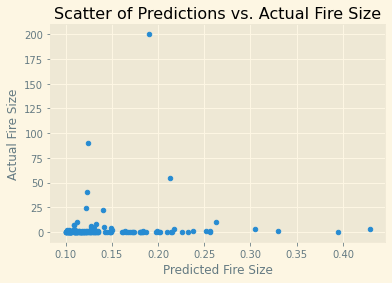

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('Solarize_Light2')
testing1_y.plot.scatter(x = 'predictions', y = 'Size')
plt.title('Scatter of Predictions vs. Actual Fire Size')
plt.xlabel('Predicted Fire Size')
plt.ylabel('Actual Fire Size')
plt.savefig('reg_v1.png')

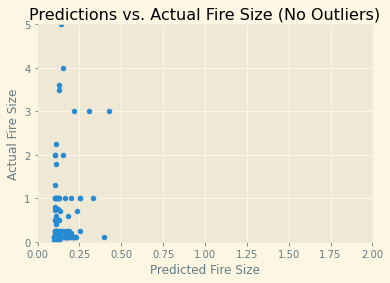

In [ ]:
testing1_y.plot.scatter(x = 'predictions', y = 'Size')
plt.title('Predictions vs. Actual Fire Size (No Outliers)')
plt.xlabel('Predicted Fire Size')
plt.ylabel('Actual Fire Size')
plt.xlim(0, 2)
plt.ylim(0, 5)
plt.savefig('reg_v2.png')

Neural Network

In [ ]:
from tensorflow.python.keras import models
from tensorflow.python.keras import layers

In [ ]:
verification2_y = testing1[['Size']]
testing2_y = testing1[['Size']]
model = models.Sequential()
model.add(layers.Dense(8, activation = 'relu', input_shape = (6, )))
model.add(layers.Dense(8, activation = 'relu'))
model.add(layers.Dense(1, activation = 'softmax'))
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_logarithmic_error', metrics = ['accuracy'])
# training
vis = model.fit(training1_x, training1_y, epochs = 4, batch_size = 16, validation_data=(verification1_x, verification2_y))
# testing
test_results = model.evaluate(testing1_x, testing2_y)

Epoch 1/4
77/77 [==============================] - 0s 4ms/step - loss: 1.2988 - accuracy: 0.1078 - val_loss: 0.9614 - val_accuracy: 0.1176
Epoch 2/4
77/77 [==============================] - 0s 2ms/step - loss: 1.2988 - accuracy: 0.1078 - val_loss: 0.9614 - val_accuracy: 0.1176
Epoch 3/4
77/77 [==============================] - 0s 3ms/step - loss: 1.2988 - accuracy: 0.1078 - val_loss: 0.9614 - val_accuracy: 0.1176
Epoch 4/4
5/5 [==============================] - 0s 1ms/step - loss: 0.9614 - accuracy: 0.1176


Visualization:

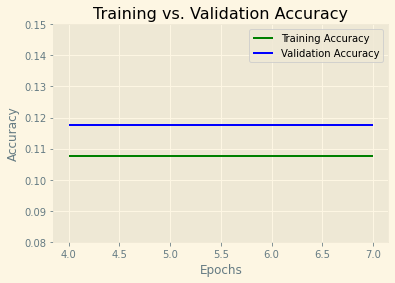

<Figure size 432x288 with 0 Axes>

In [ ]:
acc_train = np.array(vis.history['accuracy'])
acc_val = np.array(vis.history['val_accuracy'])
epochs = np.arange(4,8)
plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.08, 0.15)
plt.legend()
plt.show()
plt.savefig('nn.png')